# **"Exploring Global Culinary Diversity"** 
## **A Network Analysis of Ingredients and Countries**
In this notebook, we will explore network analysis applied to a dataset of cooking recipes. The goal of this analysis is to discover patterns and relationships in the ingredients and countries of origin of the recipes.

In particular, we will use tools such as Gephi and NetworkX to create visualizations of the network of ingredients and countries and to calculate measures of centrality and modularity in the network.

**Let's get started on the recipe, ingredient, and country network analysis!**

Necessary Imports

In [1]:
# * -----------------------------Necessary Imports ----------------------------- #
import pandas as pd
import matplotlib.pyplot as plt
from utils import DataLoader, filter_recipes_by_ingredients, detect_uncommon_ingredients, filter_uncommon_ingredients

### Create Data Frames for each csv files.

The DataLoader instance loads four different DataFrames from csv files:

- `df_recipe`: contains information about different recipe IDs, recipe names, and other recipe details.
- `df_ingredients`: contains information about ingredient names, synonyms, and entity IDs.
- `df_compound_ingredients`: contains information about compound ingredient names, synonyms, and constituent ingredients.
- `df_relation_recipe_ingredients`: contains information about the relationship between recipe IDs and ingredient names, as well as the original ingredient names and entity IDs.

In [2]:
df_recipe = DataLoader("database/01_Recipe_Details.csv","csv").load_data()
df_ingredients = DataLoader("database/02_Ingredients.csv","csv").load_data()
df_compound_ingredients = DataLoader("database/03_Compound_Ingredients.csv", "csv").load_data()
df_relation_recipe_ingredients = DataLoader("database/04_Recipe-Ingredients_Aliases.csv", "csv").load_data()

#Renaming the Colums 
df_recipe = df_recipe.rename(columns={"Recipe ID": "Recipe_ID"})
df_ingredients = df_ingredients.rename(columns={"Aliased Ingredient Name": "Ingredient_Name", "Ingredient Synonyms": "Synonyms", "Entity ID": "Entity_ID"})
df_compound_ingredients = df_compound_ingredients.rename(columns={"entity id": "Entity_ID","Compound Ingredient Name": "Compound_Name","Compound Ingredient Synonyms": "Compound_Synonyms","Contituent Ingredients": "Contituent"})
df_relation_recipe_ingredients = df_relation_recipe_ingredients.rename(columns={"Recipe ID": "Recipe_ID","Original Ingredient Name": "Original_Name", "Aliased Ingredient Name": "Ingredient_Name", "Entity ID": "Entity_ID" })

- **First**, we'll rename some of the columns to make them easier to work with

In [3]:
def add_ingredients_to_recipe(df_recipe, df_relation_recipe_ingredients):
    # Agrupar los ingredientes por receta
    ingredientes_por_receta = df_relation_recipe_ingredients.groupby("Recipe_ID")["Ingredient_Name"].apply(set)
    # Crear una nueva columna en el dataframe de recetas con los ingredientes
    df_recipe["Ingredient_Name"] = df_recipe["Recipe_ID"].apply(lambda x: ingredientes_por_receta.get(x, set()))
    return df_recipe

df_recipe_analysis= add_ingredients_to_recipe(df_recipe,df_relation_recipe_ingredients)
#pd.set_option('display.max_rows', None)
# df_recipe_analysis = df_recipe_analysis.drop('Source', axis=1)

count_by_country = df_recipe_analysis.groupby('Cuisine')['Recipe_ID'].count()
count_by_country

Cuisine
Africa                      651
Australia & NZ              494
British Isles              1075
Canada                     1112
Caribbean                  1103
China                       941
DACH Countries              487
Eastern Europe              565
France                     2703
Greece                      934
Indian Subcontinent        4058
Italy                      7504
Japan                       580
Korea                       301
Mexico                     3138
Middle East                 993
Misc.: Belgian               15
Misc.: Central America       14
Misc.: Dutch                 40
Misc.: Portugal             138
Scandinavia                 404
South America               310
South East Asia             611
Spain                       816
Thailand                    667
USA                       16118
Name: Recipe_ID, dtype: int64

## **General Information**
- Total de Recetas por paises analizados
  

Text(0.5, 1.0, 'Number of recipes per country before cleaning the data')

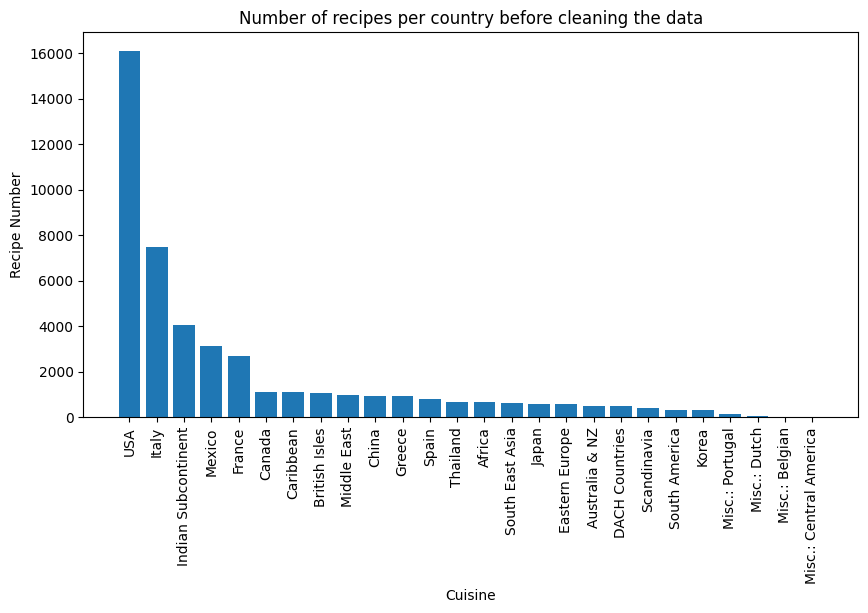

In [4]:
#Total de recetas iniciales
recipes_by_cousine = df_recipe_analysis.groupby("Cuisine")["Recipe_ID"].count().sort_values(ascending=False)

# Crear gráfico de barras
plt.figure(figsize=(10, 5))
plt.bar(recipes_by_cousine.index, recipes_by_cousine.values)
plt.xticks(rotation=90)
plt.xlabel("Cuisine")
plt.ylabel("Recipe Number")
plt.title("Number of recipes per country before cleaning the data")

Text(0.5, 1.0, 'Number of ingredients per country before cleaning the data')

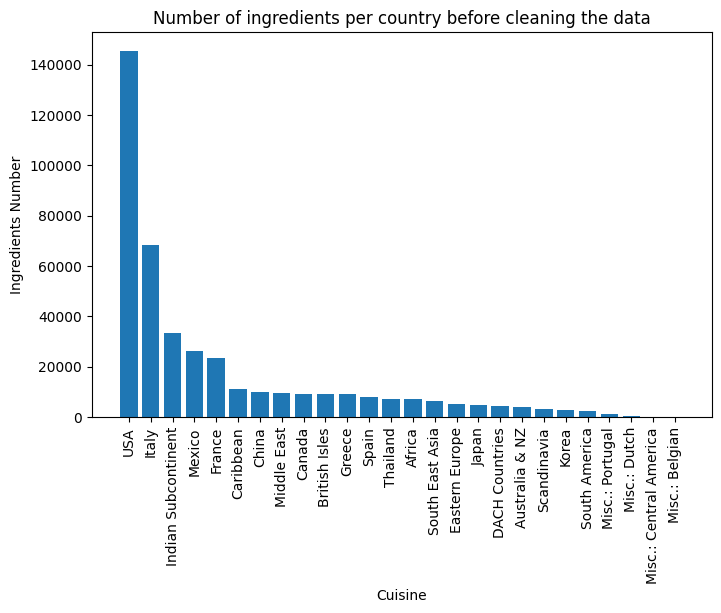

In [5]:
# Divide la columna de ingredientes en filas separadas
df_recipe_analysis_explode = df_recipe_analysis.explode('Ingredient_Name')
ingredients_by_cousine = df_recipe_analysis_explode.groupby("Cuisine")["Ingredient_Name"].count().sort_values(ascending=False)

# Crear gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(ingredients_by_cousine.index, ingredients_by_cousine.values)
plt.xticks(rotation=90)
plt.xlabel("Cuisine")
plt.ylabel("Ingredients Number")
plt.title("Number of ingredients per country before cleaning the data")


### Cleaning Data
Before we can start working with the data, we need to clean it up. 

- Delete posible null values

In [6]:
df_recipe_analysis.isna().sum()

# Seleccionamos todas las filas que no contienen la cadena 'set()'
df_recipe_analysis = df_recipe_analysis.loc[~df_recipe_analysis.astype(str).apply(lambda x: x.str.contains('set()')).any(axis=1)]

C:\Users\Giselle\AppData\Local\Temp\ipykernel_6352\192540269.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_recipe_analysis = df_recipe_analysis.loc[~df_recipe_analysis.astype(str).apply(lambda x: x.str.contains('set()')).any(axis=1)]


In [7]:
# Divide la columna de ingredientes en filas separadas
df_recipe_analysis_explode = df_recipe_analysis.explode('Ingredient_Name')
df_recipe_analysis_explode
# Agrupar por la cantidad de ingredientes por cosina
#df_recipe_analysis_explode.groupby(df_recipe_analysis_explode.Cuisine).Ingredient_Name.count()

,Recipe_ID,Title,Source,Cuisine,Ingredient_Name
0,1,5 spice vegetable fried rice,TARLA_DALAL,Indian Subcontinent,pepper bell
0,1,5 spice vegetable fried rice,TARLA_DALAL,Indian Subcontinent,capsicum
0,1,5 spice vegetable fried rice,TARLA_DALAL,Indian Subcontinent,sunflower
0,1,5 spice vegetable fried rice,TARLA_DALAL,Indian Subcontinent,soy sauce
1,2,aachar aaloo,TARLA_DALAL,Indian Subcontinent,cumin
...,...,...,...,...,...
45771,45772,Enlightened Chicken Pot Pie,EPICURIOUS,USA,worcestershire sauce
45771,45772,Enlightened Chicken Pot Pie,EPICURIOUS,USA,salt
45771,45772,Enlightened Chicken Pot Pie,EPICURIOUS,USA,potato
45771,45772,Enlightened Chicken Pot Pie,EPICURIOUS,USA,squash yellow


- Merge ingredients

In [8]:
# Definir la función de fusión de ingredientes
def merge_synonyms(df, synonyms):
    for syn in synonyms:
        preferred_name, alternate_names = syn[0], syn[1:]
        for alt in alternate_names:
            df['Ingredient_Name'] = df['Ingredient_Name'].str.replace(alt, preferred_name)
    return df

In [9]:
df_recipe_analysis_explode.loc[df_recipe_analysis_explode['Ingredient_Name'].str.contains('cheese'), 'Ingredient_Name'] = 'cheese'
df_recipe_analysis_explode.loc[df_recipe_analysis_explode['Ingredient_Name'].str.contains('zucchini'), 'Ingredient_Name'] = 'zucchini'

- Delete most common ingredients

In [10]:
# calculate the top 5 ingredients per cuisine
top_5_per_cuisine = df_recipe_analysis_explode.groupby('Cuisine')['Ingredient_Name'].apply(lambda x: x.value_counts().head(5))

top_20_per_cuisine = df_recipe_analysis_explode.groupby('Cuisine')['Ingredient_Name'].apply(lambda x: x.value_counts().head(20))
top_20_per_cuisine = top_20_per_cuisine.reset_index(name='Frequency')


df_top_5 = top_5_per_cuisine.reset_index(name='Frequency')

df_top_5 = df_top_5.rename(columns={"level_1": "Ingredient"})
total_ingredients_by_Cuisine = df_recipe_analysis.groupby('Cuisine')['Cuisine'].count()

total_ingredients_by_Cuisine = total_ingredients_by_Cuisine.reset_index(name='Frequency')

merged_df = pd.merge(total_ingredients_by_Cuisine, df_top_5, on='Cuisine')
merged_df = merged_df.rename(columns={"Frequency_x": "Total of Recipe", "Frequency_y": "Frequency" })

merged_df['Percentage'] = (merged_df['Frequency'].div(merged_df['Total of Recipe']).mul(100))
merged_df

merged_df.groupby('Ingredient')['Cuisine'].count()

Ingredient
butter         9
cayenne        1
cheese         4
cilantro       2
cinnamon       1
cumin          1
egg            8
fish           2
flour          6
garlic        16
ginger         2
lime           2
olive          8
onion         11
pepper        14
salt          20
sesame         2
soy sauce      3
sugar         13
sunflower      1
tomato         2
turmeric       1
water          1
Name: Cuisine, dtype: int64

In [11]:
#Eliminar los ingredientes recurrentes de las recetas por paises 
#salt presente como recurrente en 20 paises
df_recipe_analysis_explode = df_recipe_analysis_explode.loc[~df_recipe_analysis_explode.astype(str).apply(lambda x: x.str.contains('salt')).any(axis=1)]
#sugar presente en 15
df_recipe_analysis_explode = df_recipe_analysis_explode.loc[~df_recipe_analysis_explode.astype(str).apply(lambda x: x.str.contains('sugar')).any(axis=1)]
#garlic present in 17
df_recipe_analysis_explode = df_recipe_analysis_explode.loc[~df_recipe_analysis_explode.astype(str).apply(lambda x: x.str.contains('garlic')).any(axis=1)]

df_recipe_analysis_explode = df_recipe_analysis_explode.loc[~df_recipe_analysis_explode.astype(str).apply(lambda x: x.str.contains('pepper')).any(axis=1)]

df_recipe_analysis_explode = df_recipe_analysis_explode.loc[~df_recipe_analysis_explode.astype(str).apply(lambda x: x.str.contains('water')).any(axis=1)]

df_recipe_analysis_explode = df_recipe_analysis_explode.loc[~df_recipe_analysis_explode.astype(str).apply(lambda x: x.str.contains('onion')).any(axis=1)]

df_recipe_analysis_explode = df_recipe_analysis_explode.loc[~df_recipe_analysis_explode.astype(str).apply(lambda x: x.str.contains('olive')).any(axis=1)]

df_recipe_analysis_explode = df_recipe_analysis_explode.loc[~df_recipe_analysis_explode.astype(str).apply(lambda x: x.str.contains('egg')).any(axis=1)]

df_recipe_analysis_explode = df_recipe_analysis_explode.loc[~df_recipe_analysis_explode.astype(str).apply(lambda x: x.str.contains('butter')).any(axis=1)]

df_recipe_analysis_explode

,Recipe_ID,Title,Source,Cuisine,Ingredient_Name
0,1,5 spice vegetable fried rice,TARLA_DALAL,Indian Subcontinent,capsicum
0,1,5 spice vegetable fried rice,TARLA_DALAL,Indian Subcontinent,sunflower
0,1,5 spice vegetable fried rice,TARLA_DALAL,Indian Subcontinent,soy sauce
1,2,aachar aaloo,TARLA_DALAL,Indian Subcontinent,cumin
1,2,aachar aaloo,TARLA_DALAL,Indian Subcontinent,mustard oil
...,...,...,...,...,...
45771,45772,Enlightened Chicken Pot Pie,EPICURIOUS,USA,zucchini
45771,45772,Enlightened Chicken Pot Pie,EPICURIOUS,USA,worcestershire sauce
45771,45772,Enlightened Chicken Pot Pie,EPICURIOUS,USA,potato
45771,45772,Enlightened Chicken Pot Pie,EPICURIOUS,USA,squash yellow


- Delete recipes with one ingredient

In [12]:
# find_similar_recipes(df_recipe_analysis)
def find_recipes_with_n_ingredients(df, n):
    df_grouped = df.groupby(['Recipe_ID', 'Cuisine']).agg({'Ingredient_Name': list}).reset_index()
    df_grouped.rename(columns={'Ingredient_Name': 'Ingredient_Name'}, inplace=True)
    
    n_ingredient_recipes = []
    for i in range(len(df_grouped)):
        ingredient_count = len(df_grouped.iloc[i]['Ingredient_Name'])
        if ingredient_count == n:
            recipe_name = df_grouped.iloc[i]['Recipe_ID']
            cuisine = df_grouped.iloc[i]['Cuisine']
            n_ingredient_recipes.append(f"{recipe_name}")
    
    return n_ingredient_recipes

In [13]:
one_ingredient_recipe = find_recipes_with_n_ingredients(df_recipe_analysis_explode,1)
df_recipe_analysis_explode = filter_recipes_by_ingredients(df_recipe_analysis_explode, one_ingredient_recipe, 'Recipe_ID')
df_recipe_analysis_explode

,Recipe_ID,Title,Source,Cuisine,Ingredient_Name
0,1,5 spice vegetable fried rice,TARLA_DALAL,Indian Subcontinent,capsicum
0,1,5 spice vegetable fried rice,TARLA_DALAL,Indian Subcontinent,sunflower
0,1,5 spice vegetable fried rice,TARLA_DALAL,Indian Subcontinent,soy sauce
1,2,aachar aaloo,TARLA_DALAL,Indian Subcontinent,cumin
1,2,aachar aaloo,TARLA_DALAL,Indian Subcontinent,mustard oil
...,...,...,...,...,...
44998,44999,Apple-Sausage Stuffing,EPICURIOUS,USA,sage
44998,44999,Apple-Sausage Stuffing,EPICURIOUS,USA,pork
44998,44999,Apple-Sausage Stuffing,EPICURIOUS,USA,pork fat
44998,44999,Apple-Sausage Stuffing,EPICURIOUS,USA,nutmeg


- Delete uncommon ingredients

In [14]:
#Deteccion de Ingredientes poco Comunes
uncommon_ingredients = detect_uncommon_ingredients(df_recipe_analysis_explode)
# uncommon_ingredients

In [15]:
#Eliminar Ingredientes poco Comunes
df_uncommon_ingredients = filter_uncommon_ingredients(df_recipe_analysis_explode, uncommon_ingredients )


In [16]:
#Remove the uncommon ingredients
df_clean = filter_recipes_by_ingredients(df_recipe_analysis_explode, uncommon_ingredients, 'Ingredient_Name' )

- New relation between ingredients and countrys after cleaning the data

Text(0.5, 1.0, 'Number of ingredients per country after cleaning the data')

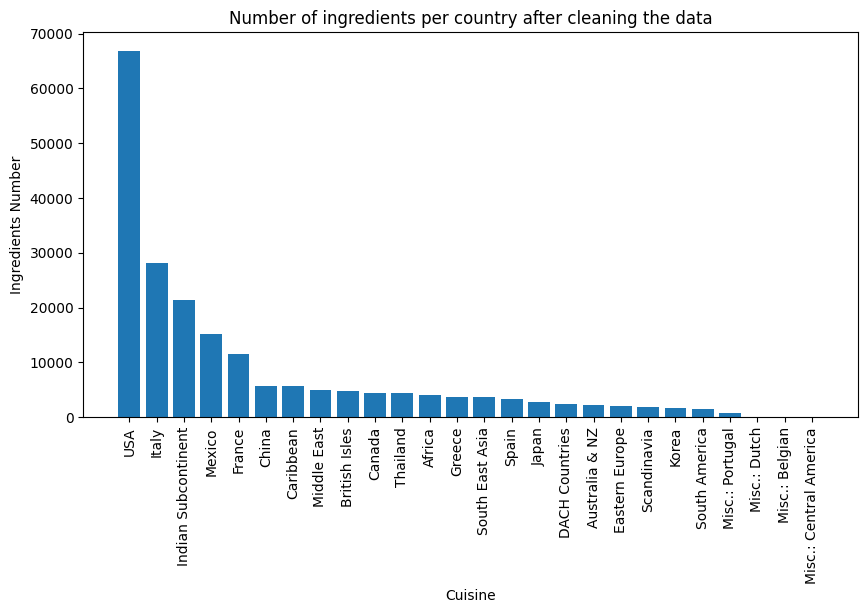

In [17]:
# Divide la columna de ingredientes en filas separadas
ingredients_by_cousine = df_clean.groupby("Cuisine")["Ingredient_Name"].count().sort_values(ascending=False)

# Crear gráfico de barras
plt.figure(figsize=(10, 5))
plt.bar(ingredients_by_cousine.index, ingredients_by_cousine.values)
plt.xticks(rotation=90)
plt.xlabel("Cuisine")
plt.ylabel("Ingredients Number")
plt.title("Number of ingredients per country after cleaning the data")

## Graph analysis and visualization

In [18]:
import networkx as nx
from networkx.algorithms import bipartite


#### Graph Creation
The graph is created from the countries and the ingredients that belong to recipes from those countries

In [19]:
G = nx.Graph()

G.add_nodes_from(df_clean.Cuisine ,bipartite = 'cuisine')
G.add_nodes_from(df_clean.Ingredient_Name,bipartite= 'ingredient')

In [20]:
cuisine = {node for node, att in G.nodes(data = True) if att['bipartite']=='cuisine'}
ingredients = set(G) - cuisine

In [21]:
# Add edges between ingredients and cuisines containing that ingredient
for ingredient in ingredients:
    ingredient_data = df_clean[df_clean['Ingredient_Name'] == ingredient]
    cuisines = ingredient_data['Cuisine'].unique()
    for cuisine in cuisines:
        cuisine_data = ingredient_data[ingredient_data['Cuisine'] == cuisine]
        num_recipes = len(cuisine_data['Recipe_ID'].unique())
        G.add_edge(ingredient, cuisine, weight=num_recipes)


# Print edges information
print(f"Total number of edges: {G.number_of_edges()}")

Total number of edges: 6737


In [22]:
#Save graph
nx.write_graphml(G, 'bipartite_graph_this.graphml')

#### Graph visualization -> Gephi

![Ejemplo de imagen](grafo.png)

### Community detection
- El analisis de comunidades se realiza desde Gephi 
- Se exporta el Data Table de Gephi

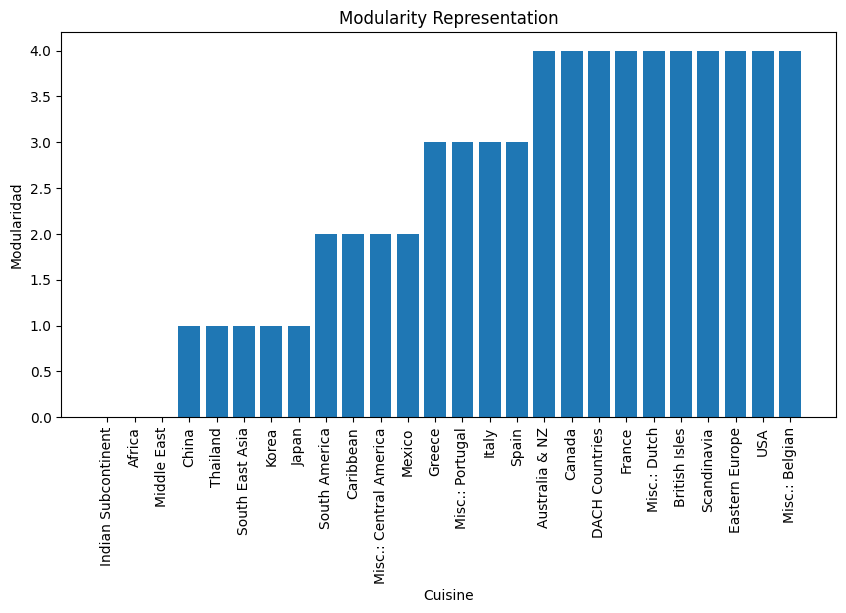

In [23]:
grafo_bipartito_df = DataLoader("database/grafo_info.csv", "csv").load_data()

# Filtrar los datos por la columna 'd0'
modularity_df = grafo_bipartito_df.loc[grafo_bipartito_df['d0'].str.contains('cuisine')]

# Ordenar el DataFrame por la columna 'modularity_class'
modularity_df = modularity_df.sort_values('modularity_class')

# Crear gráfico de dispersión
plt.figure(figsize=(10, 5))
plt.bar(modularity_df.Id, modularity_df.modularity_class)
plt.xticks(rotation=90)
plt.xlabel("Cuisine")
plt.ylabel("Modularidad")
plt.title("Modularity Representation")

# Mostrar el gráfico
plt.show()
